Hand-drawn Circuit Component Recognition <br>
Author: Apurva Umredkar<br><br>
Step 3: Training a classifier

In [2]:
# Libraries
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import time
import numpy as np
import seaborn as sns
# %cd /content/Hand-drawn-Circuit-Component-Recognition
from CktComponentRecognizer import myNet, tf


In [4]:
# Hyperparameters
BATCH_SIZE = 32
TEST_SPLIT = 0.2
NUM_EPOCHS = 10
LEARNING_RATE = 1e-3


In [5]:
# classifier step 1: loading our dataset
#DATASET_DIRECTORY = r"/content/drive/MyDrive/Hand-drawn-Circuit-Component-Recognition/dataset"
DATASET_DIRECTORY = r"./dataset"
dataset = datasets.ImageFolder(DATASET_DIRECTORY, transform=tf)
component_labels = list(dataset.class_to_idx.keys())

# checking number of samples and labels assigned
NUM_SAMPLES = len(dataset)
NUM_CLASSES = len(list(dataset.class_to_idx.values()))
print(f"Total number of samples: {NUM_SAMPLES}")
print("Labels:", dataset.class_to_idx)


Total number of samples: 20460
Labels: {'battery': 0, 'capacitor': 1, 'diode': 2, 'ground': 3, 'inductor': 4, 'led': 5, 'mosfet': 6, 'resistor': 7, 'switch': 8, 'transistor': 9}


Number of training samples: 16368
Number of testing samples: 4092
Image resolution: torch.Size([84, 84, 1])


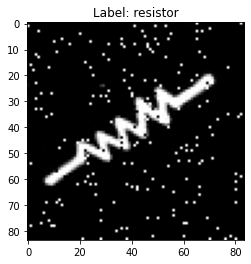

In [6]:
# classifier step 2: splitting the dataset train and test sets (80-20%)

train_size = int((1-TEST_SPLIT)*NUM_SAMPLES)
test_size = int(TEST_SPLIT*NUM_SAMPLES)

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# classifier step 3: transfering training and testing dataset into dataloader
train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

print(f"Number of training samples: {train_size}")
print(f"Number of testing samples: {test_size}")

# plotting a random training sample to verify
sample_img, sample_label = train_dataset[0]
# reshaping the tensor so it can be displayed
sample_img = sample_img.permute(1, 2, 0)
sample_label = component_labels[sample_label]

plt.imshow(sample_img, cmap="gray")
plt.title(f"Label: {sample_label}")
print(f"Image resolution: {sample_img.shape}")


In [7]:

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

# compiling the model
model = myNet() # AlexNet
model = model.to(device)
model


cuda:0


myNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 24, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(24, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=800, out_features=320, bias=True)
  (fc2): Linear(in_features=320, out_features=80, bias=True)
  (fc3): Linear(in_features=80, out_features=10, bias=True)
)

In [8]:
# classifier step 4: training the network
# defining loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, amsgrad=True)

training_acc = []
training_loss = []
total_time = 0
print("Training Classifier")
for epoch in range(NUM_EPOCHS):
  correct = 0
  total = 0
  start = time.time()
  model.train()
  print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
  for i, (inputs, labels) in enumerate(train_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    outputs = model(inputs)

    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    acc = 100 * correct / total

    loss = loss_function(outputs, labels)
    loss.backward()
    optimizer.step()
    if i%(len(train_dataloader)//5) == 0 or i == len(train_dataloader)-1:
      print(f"  Mini-batch: {i+1}/{len(train_dataloader)} >> Training Accuracy: {acc:.4f}%  Training Loss: {loss:.4f}")

  print(f"Time taken: {time.time() - start:.2f}s")
  total_time += time.time() - start
  training_acc.append(acc)
  training_loss.append(loss)

print(f"Total training time: {total_time:.2f}s")


Training Classifier
Epoch 1/10


d:\VNIT ECE\ECE 8th Sem\ML\PROJECT\Hand-drawn-Circuit-Component-Recognition\CktComponentRecognizer.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc3(x))


  Mini-batch: 1/512 >> Training Accuracy: 12.5000%  Training Loss: 2.3019
  Mini-batch: 103/512 >> Training Accuracy: 22.0267%  Training Loss: 2.0907
  Mini-batch: 205/512 >> Training Accuracy: 31.6768%  Training Loss: 1.9144
  Mini-batch: 307/512 >> Training Accuracy: 37.8257%  Training Loss: 2.0164
  Mini-batch: 409/512 >> Training Accuracy: 42.0996%  Training Loss: 1.8509
  Mini-batch: 511/512 >> Training Accuracy: 45.3156%  Training Loss: 1.8137
  Mini-batch: 512/512 >> Training Accuracy: 45.3140%  Training Loss: 2.0441
Time taken: 358.26s
Epoch 2/10
  Mini-batch: 1/512 >> Training Accuracy: 65.6250%  Training Loss: 1.8205
  Mini-batch: 103/512 >> Training Accuracy: 61.7112%  Training Loss: 1.7476
  Mini-batch: 205/512 >> Training Accuracy: 62.5610%  Training Loss: 1.8021
  Mini-batch: 307/512 >> Training Accuracy: 64.0472%  Training Loss: 1.8403
  Mini-batch: 409/512 >> Training Accuracy: 64.9297%  Training Loss: 1.6979
  Mini-batch: 511/512 >> Training Accuracy: 65.6128%  Trainin

Training performance


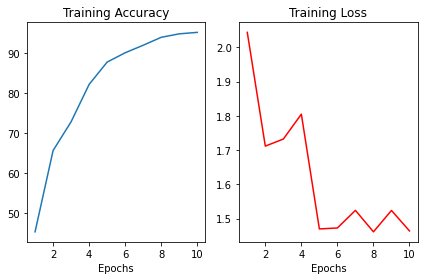

In [9]:
# plotting the training graphs over all epochs
epochs = np.arange(1, NUM_EPOCHS+1)
training_loss = [float(i) for i in training_loss]
f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
ax1.plot(epochs, training_acc)
ax1.set_title("Training Accuracy")
ax1.set_xlabel("Epochs")
ax2.plot(epochs, training_loss, "r")
ax2.set_title("Training Loss")
ax2.set_xlabel("Epochs")
plt.tight_layout()
print("Training performance")


In [11]:
correct = 0
total = 0
confmat = np.zeros((NUM_CLASSES, NUM_CLASSES))
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():

  for i, data in enumerate(test_dataloader):
    images, labels = data[0].to(device), data[1].to(device)
    # calculate outputs by running images through the network
    outputs = model(images)
    # the class with the highest energy is what we choose as prediction
    _, predicted = torch.max(outputs.data, 1)
    loss = loss_function(outputs, labels)

    for i in range(labels.size(0)):
      pred_idx = int(predicted[i])
      lbl_idx = int(labels[i])
      confmat[lbl_idx, pred_idx] += 1

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(f'Accuracy: {100 * correct / total:.4f} % Loss: {loss/i:.4f}')


Accuracy: 94.9413 % Loss: 0.0566


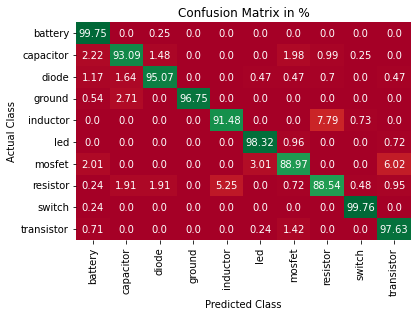

In [12]:
test_samples_per_class = torch.zeros(NUM_CLASSES)
for test in test_dataloader:
    test_samples_per_class += torch.bincount(test[1], minlength=NUM_CLASSES)

confmat_percent = np.zeros_like(confmat)
for i in range(NUM_CLASSES):
    for j in range(NUM_CLASSES):
        confmat_percent[i, j] = np.round(
            100*confmat[i, j]/int(test_samples_per_class[i]), 2)

confmat_heatmap = sns.heatmap(confmat_percent, annot=True, fmt='', cmap='RdYlGn',
                              cbar=False, yticklabels=component_labels, xticklabels=component_labels, vmin=0)
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.title('Confusion Matrix in %')
plt.show()


In [13]:
# saving the entire model
torch.save(model, "CktComponentRecognizer.pt")


